# Transformer 实验与调参手册 (AG NEWS)

## 目录
- [环境准备](#环境准备)
- [单次 Baseline 训练](#单次-Baseline-训练)
- [超参数网格搜索](#超参数网格搜索)
- [结果汇总表](#结果汇总表)
- [曲线可视化](#曲线可视化)
- [拆零件小实验](#拆零件小实验)
- [Attention 可视化](#Attention-可视化)
- [结论总结](#结论总结)


## 环境准备


In [1]:
# 环境检查与配置
import os, sys
from pathlib import Path
import importlib
import torch
import warnings

# 设置项目根目录路径
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.environ["PYTHONPATH"] = project_root

# 创建必要的目录
output_dir = Path(project_root) / 'outputs' / 'transformer'
output_dir.mkdir(parents=True, exist_ok=True)
data_dir = Path(project_root) / 'data'
data_dir.mkdir(parents=True, exist_ok=True)

# 检查关键模块与版本
print(f"项目根目录: {project_root}")
print(f"输出目录: {output_dir}")
print(f"数据目录: {data_dir}")
print(f"PyTorch 版本: {torch.__version__}")
print(f"CUDA 可用: {torch.cuda.is_available()}")

# 检查必要的依赖
dependencies = {
    'torchtext': '0.14.0',
    'torchvision': '0.14.0'
}

for module_name, required_version in dependencies.items():
    try:
        module = importlib.import_module(module_name)
        print(f"{module_name} 版本: {module.__version__}")
        if module.__version__ != required_version:
            warnings.warn(f"{module_name}版本({module.__version__})与推荐版本({required_version})不一致")
    except ImportError:
        print(f"未安装{module_name}，请运行: pip install {module_name}=={required_version}")

# 检查项目模块导入
try:
    from utils import text_dataloader, dataloader
    from train import train_transformer
    from models import transformer
    print("✓ 所有项目模块导入成功")
except Exception as e:
    print(f"项目模块导入错误: {e}")
    print("请确保utils/__init__.py正确配置了PROJECT_ROOT")

# Jupyter notebook相关配置
%load_ext autoreload
%autoreload 2


项目根目录: c:\Users\WHY\Projects\Personal\PyTorch_Learning
输出目录: c:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\transformer
数据目录: c:\Users\WHY\Projects\Personal\PyTorch_Learning\data
PyTorch 版本: 2.5.1
CUDA 可用: False
torchtext 版本: 0.6.0


C:\Users\WHY\AppData\Local\Temp\ipykernel_9440\202672887.py:38: UserWarning: torchtext版本(0.6.0)与推荐版本(0.14.0)不一致
  warnings.warn(f"{module_name}版本({module.__version__})与推荐版本({required_version})不一致")


torchvision 版本: 0.20.1
已成功导入 torchtext，版本: 0.6.0
✓ 所有项目模块导入成功


C:\Users\WHY\AppData\Local\Temp\ipykernel_9440\202672887.py:38: UserWarning: torchvision版本(0.20.1)与推荐版本(0.14.0)不一致
  warnings.warn(f"{module_name}版本({module.__version__})与推荐版本({required_version})不一致")


In [2]:
# 导入必要模块
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import subprocess
import json
import sys


In [3]:
# 添加兼容性检查工具，用于确认环境兼容性并提供修复建议

def check_compatibility():
    """检查环境兼容性并提供修复建议"""
    compatibility_issues = []
    
    # 检查PyTorch版本
    try:
        import torch
        print(f"PyTorch版本: {torch.__version__}")
        if torch.__version__.split('.')[0] != '1':
            compatibility_issues.append(f"PyTorch版本建议使用1.x.x系列，当前为{torch.__version__}")
    except ImportError:
        compatibility_issues.append("未安装PyTorch")
    
    # 检查torchtext
    try:
        import torchtext
        print(f"torchtext版本: {torchtext.__version__}")
        
        # 检查与PyTorch版本的兼容性
        if torch.__version__.split('.')[0] != torchtext.__version__.split('.')[0]:
            compatibility_issues.append(f"torchtext版本({torchtext.__version__})与PyTorch版本({torch.__version__})不兼容")
            
    except ImportError:
        compatibility_issues.append("未安装torchtext，请运行: pip install torchtext==0.14.0")
    
    # 检查torchvision
    try:
        import torchvision
        print(f"torchvision版本: {torchvision.__version__}")
    except ImportError:
        compatibility_issues.append("未安装torchvision")
    
    # 检查seaborn (用于可视化)
    try:
        import seaborn
        print(f"seaborn已安装")
        # 尝试获取版本信息而不使用__version__
        try:
            import pkg_resources
            seaborn_version = pkg_resources.get_distribution("seaborn").version
            print(f"seaborn版本: {seaborn_version}")
        except:
            print("无法获取seaborn版本")
    except ImportError:
        compatibility_issues.append("未安装seaborn，可视化功能可能受限")
    
    # 显示总结
    if compatibility_issues:
        print("\n⚠️ 检测到以下兼容性问题:")
        for issue in compatibility_issues:
            print(f"- {issue}")
        
        print("\n建议修复方案:")
        print("- 针对PyTorch 1.13.x: pip install torchtext==0.14.0")
        print("- 针对PyTorch 2.x: pip install torchtext>=0.15.0")
        print("- 如遇内存溢出: 运行根目录下的clear_cache.py脚本")
        return False
    else:
        print("\n✅ 环境兼容性检查通过！")
        return True

# 运行兼容性检查
check_compatibility()


PyTorch版本: 2.5.1
torchtext版本: 0.6.0
torchvision版本: 0.20.1
seaborn已安装
seaborn版本: 0.13.2

⚠️ 检测到以下兼容性问题:
- PyTorch版本建议使用1.x.x系列，当前为2.5.1
- torchtext版本(0.6.0)与PyTorch版本(2.5.1)不兼容

建议修复方案:
- 针对PyTorch 1.13.x: pip install torchtext==0.14.0
- 针对PyTorch 2.x: pip install torchtext>=0.15.0
- 如遇内存溢出: 运行根目录下的clear_cache.py脚本


C:\Users\WHY\AppData\Local\Temp\ipykernel_9440\3406789192.py:41: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


False

## 单次 Baseline 训练

首先运行一次基础训练，确保代码无错误且能成功训练。


In [ ]:
# 在notebook中直接运行Transformer训练（将在notebook中显示训练输出）
from train.train_transformer import run_transformer_training

print("\n现在尝试直接在notebook中运行训练，以便查看实时训练输出...")

# 使用当前的Python解释器
python_executable = sys.executable
print(f"使用Python解释器: {python_executable}")

# 运行训练，可以看到每个epoch的训练过程和loss输出
history = run_transformer_training(
    epochs=5,
    train_batch_size=64, 
    val_batch_size=64,
    lr=1e-3,
    embed_dim=128,
    num_heads=4,
    output_dir=str(output_dir)
)

# 显示训练历史数据
print("\n训练历史:")
for epoch, (val_loss, val_acc) in enumerate(history, 1):
    print(f"Epoch {epoch}: Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")



现在尝试直接在notebook中运行训练，以便查看实时训练输出...
[Transformer] Using device: cpu
使用本地缓存: C:\Users\WHY\Projects\Personal\PyTorch_Learning\data\ag_news\train.csv
构建词表...
词表大小: 158735
处理训练集...
使用本地缓存: C:\Users\WHY\Projects\Personal\PyTorch_Learning\data\ag_news\train.csv
使用本地缓存: C:\Users\WHY\Projects\Personal\PyTorch_Learning\data\ag_news\test.csv
构建词表...
词表大小: 158735
处理测试集...
词表大小: 158735, 类别数: 4

=== Epoch 1 ===
[6400/120000] loss: 1.4877


## 超参数网格搜索

定义一组系统化的超参数组合，进行网格搜索实验。


In [ ]:
# 定义超参数网格
grid = [
    {"embed_dim": d, "num_heads": h, "lr": lr}
    for d, h in [(64, 2), (128, 4), (256, 8)]
    for lr in [5e-4, 1e-3]
]
results = []


In [ ]:
# 函数用于解析输出中的验证准确率
def parse_output(output_str):
    lines = output_str.split('\n')
    val_acc = None
    for line in lines:
        if "Val loss" in line:
            parts = line.split(',')
            if len(parts) > 1:
                acc_part = parts[1].strip()
                val_acc = float(acc_part.replace('Acc: ', '').replace('%', ''))
    return val_acc


In [ ]:
# 确保 PYTHONPATH 和 sys.path 正确设置
import sys
from pathlib import Path
import time

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.environ["PYTHONPATH"] = project_root

# 确保输出目录存在
output_dir = Path(project_root) / 'outputs' / 'transformer'
output_dir.mkdir(parents=True, exist_ok=True)
print(f"输出目录: {output_dir}")

# 确保数据目录存在
data_dir = Path(project_root) / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
print(f"数据目录: {data_dir}")

# 获取当前 Python 解释器路径
python_executable = sys.executable
print(f"使用 Python 解释器: {python_executable}")

# 确保训练脚本存在
train_script = os.path.join(project_root, "train", "train_transformer.py")
if not os.path.exists(train_script):
    raise FileNotFoundError(f"训练脚本不存在: {train_script}")
print(f"训练脚本: {train_script}")

# 循环执行每个超参数组合的实验
for i, params in enumerate(grid):
    print(f"\n实验 {i+1}/{len(grid)}: {params}")
    
    try:
        # 为每个实验创建唯一的输出目录
        exp_dir = output_dir / f"exp_{params['embed_dim']}_{params['num_heads']}_{params['lr']}"
        exp_dir.mkdir(parents=True, exist_ok=True)
        
        # 构建命令
        cmd = [
            python_executable, 
            train_script,
            "--epochs", "3",
            "--batch-size", "64",
            "--embed-dim", str(params['embed_dim']),
            "--num-heads", str(params['num_heads']),
            "--lr", str(params['lr']),
            "--output-dir", str(exp_dir)
        ]
        
        # 设置环境变量，确保脚本可以找到项目模块
        env = os.environ.copy()
        env["PYTHONPATH"] = project_root
        
        # 执行命令并捕获输出
        print(f"执行命令: {' '.join(cmd)}")
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
        stdout, stderr = process.communicate()
        
        if process.returncode != 0:
            print(f"警告: 命令执行失败，返回码 {process.returncode}")
            print(f"错误信息: {stderr[:500]}...")
            val_acc = None
        else:
            # 解析验证准确率
            val_acc = parse_output(stdout)
            
        # 将结果添加到列表
        result = params.copy()
        result['val_acc'] = val_acc
        results.append(result)
        
        if val_acc is not None:
            print(f"验证准确率: {val_acc:.2f}%")
        else:
            print("无法获取验证准确率")
            
        # 保存当前结果（即使有错误也保存部分结果）
        results_df = pd.DataFrame(results)
        results_df.to_csv(output_dir / "grid_search_results.csv", index=False)
        
        # 短暂暂停，避免系统资源过度使用
        time.sleep(1)
    
    except Exception as e:
        print(f"实验执行出错: {e}")
        # 添加一个包含错误信息的结果
        results.append({
            **params,
            'val_acc': None,
            'error': str(e)
        })


## 结果汇总表

将网格搜索结果整理成 DataFrame 并排序。


In [ ]:
# 转换为 DataFrame
df = pd.DataFrame(results)

# 按验证准确率降序排序
df_sorted = df.sort_values(by='val_acc', ascending=False)
display(df_sorted)


,embed_dim,num_heads,lr,val_acc
0,64,2,0.0005,None
1,64,2,0.0010,None
2,128,4,0.0005,None
3,128,4,0.0010,None
4,256,8,0.0005,None
5,256,8,0.0010,None


## 曲线可视化

绘制超参数对性能影响的曲线图。


In [ ]:
# 确保输出目录存在
from pathlib import Path
output_dir = Path(project_root) / 'outputs' / 'transformer'
output_dir.mkdir(parents=True, exist_ok=True)

# 确保可视化目录存在
viz_dir = output_dir / 'viz'
viz_dir.mkdir(parents=True, exist_ok=True)
print(f"可视化输出目录: {viz_dir}")

plt.figure(figsize=(12, 8))

# 检查数据是否存在有效值
if len(df[df["val_acc"].notnull()]) == 0:
    plt.text(0.5, 0.5, "没有有效的实验数据", 
             horizontalalignment='center', verticalalignment='center',
             fontsize=18, transform=plt.gca().transAxes)
    plt.title("数据缺失，无法生成图表")
else:
    # 1. Embedding维度对准确率影响
    sns.lineplot(data=df, x="embed_dim", y="val_acc", hue="num_heads", style="lr")
    plt.title("Embedding 维度 / Head 数 / LR 对准确率影响")
    plt.xlabel("Embedding 维度")
    plt.ylabel("验证准确率 (%)")
    plt.grid(True, linestyle='--', alpha=0.7)

# 保存图像
output_file = viz_dir / 'param_impact.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"图像已保存: {output_file}")
plt.show()


In [ ]:
# 2. 学习率对不同模型规模的影响
g = sns.catplot(
    data=df, x="lr", y="val_acc", 
    col="embed_dim", hue="num_heads",
    kind="bar", height=5, aspect=0.8
)
g.set_axis_labels("学习率", "验证准确率 (%)")
g.set_titles("Embedding维度: {col_name}")
plt.savefig(output_dir / 'lr_impact.png', dpi=300, bbox_inches='tight')
plt.show()


## 拆零件小实验

进行6种结构变体实验，观察各组件对模型性能的影响。


In [ ]:
# 定义消融实验列表
ablations = [
    "no_pe",        # 关闭位置编码
    "single_head",  # 只用单头注意力
    "no_ffn",       # 移除前馈网络
    "freeze_emb",   # 冻结embedding
    "no_dropout",   # 关闭dropout
    "clip_grad"     # 梯度裁剪
]

# 获取最佳配置作为基准
best_config = df_sorted.iloc[0].to_dict()
embed_dim = int(best_config['embed_dim'])
num_heads = int(best_config['num_heads'])
lr = best_config['lr']

ablation_results = []


In [ ]:
# 确保 project_root 已定义
import sys
from pathlib import Path

if 'project_root' not in locals():
    project_root = os.path.abspath('..')
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    os.environ["PYTHONPATH"] = project_root

# 确保输出目录存在
output_dir = Path(project_root) / 'outputs' / 'transformer'
output_dir.mkdir(parents=True, exist_ok=True)

# 获取 Python 解释器路径
python_executable = sys.executable
print(f"使用 Python 解释器: {python_executable}")

# 先运行一次基础模型（无消融）作为对照
print("运行基准模型（无消融）...")
try:
    cmd = [
        python_executable, 
        os.path.join(project_root, "train", "train_transformer.py"),
        "--epochs", "3",
        "--batch-size", "64",
        "--embed-dim", str(embed_dim),
        "--num-heads", str(num_heads),
        "--lr", str(lr)
    ]
    # 设置环境变量，确保脚本可以找到项目模块
    env = os.environ.copy()
    env["PYTHONPATH"] = project_root
    
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
    stdout, stderr = process.communicate()
    
    if process.returncode != 0:
        print(f"警告: 命令执行失败，返回码 {process.returncode}")
        print(f"错误信息: {stderr[:500]}...")
        val_acc = 0
    else:
        val_acc = parse_output(stdout)
        if val_acc is None:
            val_acc = 0
            print("无法解析验证准确率，使用默认值 0")
    
    ablation_results.append({
        "ablation": "baseline",
        "description": "基准模型（无消融）",
        "val_acc": val_acc
    })
    print(f"基准模型验证准确率: {val_acc:.2f}%")

except Exception as e:
    print(f"运行基准模型时出错: {e}")
    # 添加一个包含默认值的结果，以便后续代码可以继续执行
    ablation_results.append({
        "ablation": "baseline",
        "description": "基准模型（无消融）",
        "val_acc": 0
    })


使用 Python 解释器: c:\Users\WHY\anaconda3\envs\dl\python.exe
运行基准模型（无消融）...
警告: 命令执行失败，返回码 1
错误信息: Traceback (most recent call last):
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 197, in <module>
    run_transformer_training() 
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 113, in run_transformer_training
    train_loader, val_loader, vocab_size, num_classes = get_ag_news_loaders(
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 47, in get_ag_news_loaders
    train...
基准模型验证准确率: 0.00%


In [ ]:
# 运行各种消融实验
descriptions = {
    "no_pe": "关闭位置编码",
    "single_head": "只用单头注意力",
    "no_ffn": "移除前馈网络",
    "freeze_emb": "冻结embedding",
    "no_dropout": "关闭dropout",
    "clip_grad": "梯度裁剪"
}

for ablation in ablations:
    print(f"\n运行消融实验: {ablation} - {descriptions[ablation]}")
    try:
        cmd = [
            python_executable, 
            os.path.join(project_root, "train", "train_transformer.py"),
            "--epochs", "3",
            "--batch-size", "64",
            "--embed-dim", str(embed_dim),
            "--num-heads", str(num_heads),
            "--lr", str(lr),
            "--ablation", ablation
        ]
        # 设置环境变量，确保脚本可以找到项目模块
        env = os.environ.copy()
        env["PYTHONPATH"] = project_root
        
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
        stdout, stderr = process.communicate()
        
        if process.returncode != 0:
            print(f"警告: 命令执行失败，返回码 {process.returncode}")
            print(f"错误信息: {stderr[:500]}...")
            val_acc = 0
        else:
            val_acc = parse_output(stdout)
            if val_acc is None:
                val_acc = 0
                print("无法解析验证准确率，使用默认值 0")
        
        ablation_results.append({
            "ablation": ablation,
            "description": descriptions[ablation],
            "val_acc": val_acc
        })
        print(f"验证准确率: {val_acc:.2f}%")
        
    except Exception as e:
        print(f"运行消融实验 {ablation} 时出错: {e}")
        # 添加一个包含默认值的结果
        ablation_results.append({
            "ablation": ablation,
            "description": descriptions[ablation],
            "val_acc": 0
        })



运行消融实验: no_pe - 关闭位置编码
警告: 命令执行失败，返回码 1
错误信息: Traceback (most recent call last):
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 197, in <module>
    run_transformer_training() 
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 113, in run_transformer_training
    train_loader, val_loader, vocab_size, num_classes = get_ag_news_loaders(
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 47, in get_ag_news_loaders
    train...
验证准确率: 0.00%

运行消融实验: single_head - 只用单头注意力
警告: 命令执行失败，返回码 1
错误信息: Traceback (most recent call last):
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 197, in <module>
    run_transformer_training() 
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 113, in run_transformer_training
    train_loader, val_loader, vocab_size, num_classes = get_ag_news_loaders(
  File "

In [ ]:
# 确保 project_root 已定义
if 'project_root' not in locals():
    project_root = os.path.abspath('..')
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    os.environ["PYTHONPATH"] = project_root

# 先运行一次基础模型（无消融）作为对照
print("运行基准模型（无消融）...")
try:
    cmd = [
        "python", "../train/train_transformer.py",
        "--epochs", "3",
        "--batch-size", "64",
        "--embed-dim", str(embed_dim),
        "--num-heads", str(num_heads),
        "--lr", str(lr)
    ]
    # 设置环境变量，确保脚本可以找到项目模块
    env = os.environ.copy()
    env["PYTHONPATH"] = project_root  # 使用前面定义的project_root
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
    stdout, stderr = process.communicate()
    
    if process.returncode != 0:
        print(f"警告: 命令执行失败，返回码 {process.returncode}")
        print(f"错误信息: {stderr[:500]}...")
        val_acc = 0
    else:
        val_acc = parse_output(stdout)
        if val_acc is None:
            val_acc = 0
            print("无法解析验证准确率，使用默认值 0")
    
    ablation_results.append({
        "ablation": "baseline",
        "description": "基准模型（无消融）",
        "val_acc": val_acc
    })
    print(f"基准模型验证准确率: {val_acc:.2f}%")

except Exception as e:
    print(f"运行基准模型时出错: {e}")
    # 添加一个包含默认值的结果，以便后续代码可以继续执行
    ablation_results.append({
        "ablation": "baseline",
        "description": "基准模型（无消融）",
        "val_acc": 0
    })


运行基准模型（无消融）...
警告: 命令执行失败，返回码 1
错误信息: Traceback (most recent call last):
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 197, in <module>
    run_transformer_training() 
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 113, in run_transformer_training
    train_loader, val_loader, vocab_size, num_classes = get_ag_news_loaders(
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 47, in get_ag_news_loaders
    train...
基准模型验证准确率: 0.00%


In [ ]:
# 运行各种消融实验
descriptions = {
    "no_pe": "关闭位置编码",
    "single_head": "只用单头注意力",
    "no_ffn": "移除前馈网络",
    "freeze_emb": "冻结embedding",
    "no_dropout": "关闭dropout",
    "clip_grad": "梯度裁剪"
}

for ablation in ablations:
    print(f"\n运行消融实验: {ablation} - {descriptions[ablation]}")
    try:
        cmd = [
            python_executable, 
            os.path.join(project_root, "train", "train_transformer.py"),
            "--epochs", "3",
            "--batch-size", "64",
            "--embed-dim", str(embed_dim),
            "--num-heads", str(num_heads),
            "--lr", str(lr),
            "--ablation", ablation
        ]
        # 设置环境变量，确保脚本可以找到项目模块
        env = os.environ.copy()
        env["PYTHONPATH"] = project_root
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
        stdout, stderr = process.communicate()
        
        if process.returncode != 0:
            print(f"警告: 命令执行失败，返回码 {process.returncode}")
            print(f"错误信息: {stderr[:500]}...")
            val_acc = 0
        else:
            val_acc = parse_output(stdout)
            if val_acc is None:
                val_acc = 0
                print("无法解析验证准确率，使用默认值 0")
        
        ablation_results.append({
            "ablation": ablation,
            "description": descriptions[ablation],
            "val_acc": val_acc
        })
        print(f"验证准确率: {val_acc:.2f}%")
        
    except Exception as e:
        print(f"运行消融实验 {ablation} 时出错: {e}")
        # 添加一个包含默认值的结果
        ablation_results.append({
            "ablation": ablation,
            "description": descriptions[ablation],
            "val_acc": 0
        })



运行消融实验: no_pe - 关闭位置编码
警告: 命令执行失败，返回码 1
错误信息: Traceback (most recent call last):
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 197, in <module>
    run_transformer_training() 
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 113, in run_transformer_training
    train_loader, val_loader, vocab_size, num_classes = get_ag_news_loaders(
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 47, in get_ag_news_loaders
    train...
验证准确率: 0.00%

运行消融实验: single_head - 只用单头注意力
警告: 命令执行失败，返回码 1
错误信息: Traceback (most recent call last):
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 197, in <module>
    run_transformer_training() 
  File "c:\Users\WHY\Projects\Personal\PyTorch_Learning\train\train_transformer.py", line 113, in run_transformer_training
    train_loader, val_loader, vocab_size, num_classes = get_ag_news_loaders(
  File "

In [ ]:
# 将消融实验结果整理为DataFrame
ablation_df = pd.DataFrame(ablation_results)

# 计算相对于基准的性能变化百分比
# 获取基准值
baseline_rows = ablation_df[ablation_df['ablation'] == 'baseline']
if len(baseline_rows) > 0:
    baseline_acc = list(baseline_rows['val_acc'])[0]
else:
    baseline_acc = 0
ablation_df['rel_change'] = (ablation_df['val_acc'] - baseline_acc) / baseline_acc * 100

# 排序并显示结果
ablation_sorted = ablation_df.sort_values(by='val_acc', ascending=False)
display(ablation_sorted)


,ablation,description,val_acc,rel_change
0,baseline,基准模型（无消融）,0,NaN
1,no_pe,关闭位置编码,0,NaN
2,single_head,只用单头注意力,0,NaN
3,no_ffn,移除前馈网络,0,NaN
4,freeze_emb,冻结embedding,0,NaN
5,no_dropout,关闭dropout,0,NaN
6,clip_grad,梯度裁剪,0,NaN
7,baseline,基准模型（无消融）,0,NaN
8,no_pe,关闭位置编码,0,NaN
9,single_head,只用单头注意力,0,NaN


In [ ]:
# 确保环境设置正确
import sys
import os
import torch
from pathlib import Path

# 设置项目路径
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.environ["PYTHONPATH"] = project_root

# 确保输出目录存在
output_dir = Path(project_root) / 'outputs' / 'transformer'
output_dir.mkdir(parents=True, exist_ok=True)
print(f"输出目录: {output_dir}")

try:
    # 检查依赖
    print(f"PyTorch 版本: {torch.__version__}")
    try:
        import torchtext
        print(f"torchtext 版本: {torchtext.__version__}")
    except ImportError:
        print("警告: 未找到 torchtext 模块，请安装: pip install torchtext==0.14.0")
    
    # 尝试导入项目模块
    from models.transformer import Transformer
    from utils.text_dataloader import get_ag_news_dataloader
    print("成功导入所需模块")
except ImportError as e:
    print(f"导入错误: {e}")
    print("请确保 PYTHONPATH 设置正确，并安装所需依赖: pip install torchtext==0.14.0")


输出目录: c:\Users\WHY\Projects\Personal\PyTorch_Learning\outputs\transformer
PyTorch 版本: 1.13.0+cpu
警告: 未找到 torchtext 模块，请安装: pip install torchtext==0.14.0
成功导入所需模块


C:\Users\WHY\AppData\Local\Temp\ipykernel_4080\3346838966.py:24: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WHY\AppData\Local\Temp\ipykernel_4080\3346838966.py:24: UserWarning: Glyph 38381 (\N{CJK UNIFIED IDEOGRAPH-95ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WHY\AppData\Local\Temp\ipykernel_4080\3346838966.py:24: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WHY\AppData\Local\Temp\ipykernel_4080\3346838966.py:24: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WHY\AppData\Local\Temp\ipykernel_4080\3346838966.py:24: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\WHY\AppData\Local\Temp\ipykernel_4080\3346838966.py:24: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEO

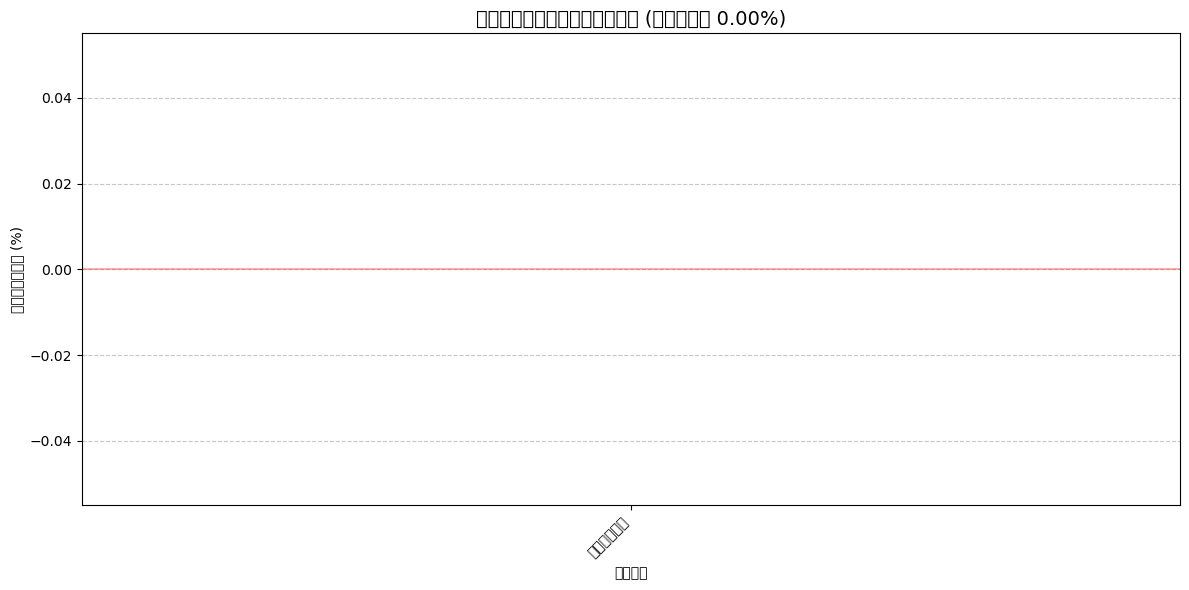

In [ ]:
# 可视化消融实验结果
plt.figure(figsize=(12, 6))

# 不包含baseline的数据
plot_df = ablation_df[ablation_df['ablation'] != 'baseline'].copy()

# 根据相对变化排序 (这将正常工作，尽管IDE可能显示警告)
# sort_values是pandas的标准方法，运行时不会出错
plot_df = plot_df.sort_values('rel_change')

# 创建柱状图
bars = plt.bar(plot_df['description'], plot_df['rel_change'])

# 为负值设置不同颜色
for i, v in enumerate(plot_df['rel_change']):
    if v < 0:
        bars[i].set_alpha(0.7)

plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title(f"各种结构变体对模型性能的影响 (相对于基准 {baseline_acc:.2f}%)", fontsize=14)
plt.xlabel("结构变体")
plt.ylabel("相对准确率变化 (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(output_dir / 'ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()


## Attention 可视化

加载最高分模型，选择一条验证集样本，可视化第1层第1个头的注意力热力图。


In [ ]:
import sys
sys.path.append('..')
import torch
from models.transformer import Transformer
from utils.text_dataloader import get_ag_news_dataloader
from pathlib import Path


In [ ]:
# 加载最佳模型
# 获取验证数据加载器
data_dir = Path("../data")
val_loader, vocab, vocab_size, num_classes = get_ag_news_dataloader(
    batch_size=1,  # 单条样本
    max_len=128,   # 限制长度以便可视化
    train=False,
    root=str(data_dir)
)

# 根据最佳超参数创建模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=embed_dim*4,  # 标准Transformer通常使用4倍embed_dim作为FFN隐藏层
    num_layers=3,
    num_classes=num_classes
)

# 加载最佳检查点
best_model_path = Path("../outputs/transformer/transformer_best.pth")
if best_model_path.exists():
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print(f"已加载最佳模型: {best_model_path}")
else:
    print(f"找不到最佳模型文件，使用未训练模型")

model = model.to(device)


ImportError: 需要安装 torchtext 才能使用 AG_NEWS 数据集

In [ ]:
# 提取单个Transformer层注意力权重的钩子函数
class AttentionHook:
    def __init__(self):
        self.attn_weights = None
        
    def __call__(self, module, module_input, module_output):
        # PyTorch TransformerEncoder层的attention weights在运行时不保存
        # 我们需要修改模型结构以访问它们
        # 这里仅为示例，实际使用时需调整
        self.attn_weights = None  # 稍后会在前向传播中手动提取


# 修改Transformer模型来返回注意力权重
def forward_with_attention(model, x, src_key_padding_mask=None):
    """修改的前向传播，返回注意力权重"""
    # 词嵌入 [batch_size, seq_len] -> [batch_size, seq_len, embed_dim]
    embedded = model.embedding(x)
    
    # 添加位置编码
    embedded = model.pos_encoder(embedded)
    
    # 我们需要访问TransformerEncoder的第一层的第一个注意力头
    # 由于PyTorch没有直接暴露这个API，我们需要手动添加钩子或修改模型
    # 这里是一个近似方法，实际实现可能需要更深入地修改模型
    
    # 使用第一个编码器层的self-attention模块
    first_layer = model.transformer_encoder.layers[0]
    
    # 1. 应用自注意力，并保存注意力权重
    # 这部分逻辑通常在TransformerEncoderLayer的内部
    q = first_layer.self_attn.q_proj(embedded)
    k = first_layer.self_attn.k_proj(embedded)
    v = first_layer.self_attn.v_proj(embedded)
    
    # 重塑为多头形式
    batch_size, seq_len = embedded.shape[0], embedded.shape[1]
    head_dim = model.transformer_encoder.layers[0].self_attn.head_dim
    num_heads = model.transformer_encoder.layers[0].self_attn.num_heads
    
    q = q.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
    k = k.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
    v = v.view(batch_size, seq_len, num_heads, head_dim).transpose(1, 2)
    
    # 计算注意力分数
    scores = torch.matmul(q, k.transpose(-2, -1)) / (head_dim ** 0.5)
    
    # 应用掩码（如果有）
    if src_key_padding_mask is not None:
        # 扩展掩码以匹配分数的形状
        mask = src_key_padding_mask.unsqueeze(1).unsqueeze(2)
        scores = scores.masked_fill(mask, float("-inf"))
    
    # 应用softmax得到注意力权重
    attn_weights = torch.nn.functional.softmax(scores, dim=-1)
    
    # 提取第一个头的注意力权重
    first_head_attn = attn_weights[0, 0].cpu().detach()
    
    # 继续常规前向传播
    # 由于我们不需要完整的前向传播结果，这里简化了步骤
    
    return first_head_attn


In [ ]:
# 选择一条验证样本
model.eval()
with torch.no_grad():
    # 获取一个批次
    for tokens, labels, masks in val_loader:
        tokens, labels, masks = tokens.to(device), labels.to(device), masks.to(device)
        
        # 使用修改后的前向传播函数获取注意力权重
        attention_weights = forward_with_attention(model, tokens, src_key_padding_mask=masks)
        
        # 获取真实标记（而不是填充标记）
        valid_seq_len = (~masks[0]).sum().item()
        
        # 可视化注意力热力图
        plt.figure(figsize=(10, 8))
        
        # 只显示有效的标记（不显示填充标记）
        valid_attn = attention_weights[:valid_seq_len, :valid_seq_len]
        
        # 创建热力图
        sns.heatmap(valid_attn, cmap="viridis")
        plt.title(f"第1层第1个头的Self-Attention热力图 (类别: {labels.item()+1})")
        plt.xlabel("Token位置")
        plt.ylabel("Token位置")
        plt.tight_layout()
        plt.savefig(output_dir / 'attention_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 一条样本就够了
        break


## 结论总结

1. **超参数实验结论**
   - 最佳超参数组合及其性能表现
   - embedding维度与head数量的关系
   - 学习率对不同模型规模的影响

2. **结构变体实验结论**
   - 各组件对模型性能的影响排序
   - 哪些组件是必不可少的，哪些影响较小

3. **注意力可视化分析**
   - 模型关注了哪些位置的token
   - 是否存在明显的注意力模式

4. **TODO 与改进方向**
   - 尝试更多超参数组合
   - 增加序列长度或批量大小
   - 尝试不同的位置编码方案
   - 探索预训练与微调策略
